## Comparison feature for QA4SM

The QA4SM web application service allows to validate one or more satellite soil moisture datasets against a reference. When a validation is run (after logging in, at `https://qa4sm.eu/validate/`), a netCDF result file is produced containing metadata and results by validation metric. 

The service makes it possible to validate multiple satellite datasets against the same reference, therefore producing a cross-comparison of the satellite products. However, this comparison is constrained by the fact that the same settings (temporal and spatial subsets, scaling method, networks, ...) are applied to all satellite-reference pairs. Comparing the performance of a satellite product across for instance different time periods or areas of the Earth is possibly of great added value to the user, but currently not implemented in the service. To allow a more informative comparison, a new feature eill be implemented in the web application in the form of a separate page, where different validations can be drawn from the user's archive and compared to one another.

This notebook gives an overview of the concept for comparison of validation results.

A comparison class can be initialized by giving a list of paths to netCDF result files. At the moment, all functionalities in the class (plots and table) work when the paths list includes 2 validations where the same reference is compared to one single satellite dataset (e.g A:B against A:C).

In [1]:
from qa4sm_reader.comparing import QA4SMComparison
import qa4sm_reader.globals
import os

os.chdir('./example_data/validations_nc')

# two validations only differ by validation period
paths = ['0-C3S.sm_with_1-GLDAS.SoilMoi0_10cm_inst.nc', '0-C3S.sm_with_1-GLDAS.SoilMoi40_100cm_inst.nc']

In [2]:
%%time
comp = QA4SMComparison(paths)

/home/pstradio/miniconda3/envs/qa4sm_reader/lib/python3.8/site-packages/h5netcdf/core.py:769: FutureWarning: String decoding changed with h5py >= 3.0. See https://docs.h5py.org/en/latest/strings.html for more details. Currently backwards compatibility with h5py < 3.0 is kept by decoding vlen strings per default. This will change in future versions for consistency with h5py >= 3.0. To silence this warning set kwarg ``decode_vlen_strings=False``. Setting ``decode_vlen_strings=True`` forces vlen string decoding.
  warnings.warn(msg, FutureWarning, stacklevel=0)


CPU times: user 228 ms, sys: 8.02 ms, total: 236 ms
Wall time: 235 ms


In [3]:
# the comparison attribute is a dictionary with {path: ID, QA4SMImg}.
#each image is assigned a name that identifies it, together with the ID:
for n, img in enumerate(comp.compared):
    print("{}-{}".format(n, img.name))

0-GLDAS (NOAH025 3H.2.1)
v C3S (v201912) (ref)
1-GLDAS (NOAH025 3H.2.1)
v C3S (v201912) (ref)


The names of the images are fundamental to tell apart the different validation results. These same names are used in the plots and table and should be unambiguous. In this case, the two validations only differ by time period and can be easily identified by includig this in the name. However, if the purpose is to compare validations with different e.g. scaling options or extents, **a different method has to be identified!**


### Performing the comparison

Here is an overview of the available methods to perform the comparison. Available metrics for comparison in the given validation are:

In [4]:
comp.common_metrics

{'p_R': "Pearson's r p-value",
 'RMSD': 'Root-mean-square deviation',
 'urmsd': 'Unbiased root-mean-square deviation',
 'rho': "Spearman's rho",
 'BIAS': 'Bias (difference of means)',
 'R': "Pearson's r",
 'mse_corr': 'Mean square error correlation',
 'mse_bias': 'Mean square error bias',
 'RSS': 'Residual sum of squares',
 'mse_var': 'Mean square error variance',
 'p_rho': "Spearman's rho p-value",
 'mse': 'Mean square error'}

#### Difference table

A first difference overview can be provided using the summary statistics of the validation results. In the table, an absolute and relative difference value between the medians of the two datasets is associated to each validation metric:

In [5]:
# just suppress warning for nans
import warnings
warnings.filterwarnings('ignore')
comp.diff_table(
    ['BIAS',
     'urmsd',
     'R',
     'mse_var',
     'mse',
     'mse_corr',
     'p_R',
     'mse_bias',
     'RSS',
     'rho',
     'p_rho',
     'RMSD']
)

,Validation 0: GLDAS (NOAH025 3H.2.1) validated against C3S (v201912),Validation 1: GLDAS (NOAH025 3H.2.1) validated against C3S (v201912),Difference of the medians (0 - 1)
Bias (difference of means) [m³/m³],~ 0,~ 0,~ 0
Unbiased root-mean-square deviation [m³/m³],3.60e-02,5.28e-02,~ 0
Pearson's r [-],0.73,0.42,0.32
Mean square error variance [(m³/m³)²],~ 0,~ 0,~ 0
Mean square error [(m³/m³)²],1.3e-03,2.79e-03,~ 0
Mean square error correlation [(m³/m³)²],1.3e-03,2.79e-03,~ 0
Pearson's r p-value [-],~ 0,~ 0,~ 0
Mean square error bias [(m³/m³)²],~ 0,~ 0,~ 0
Residual sum of squares [(m³/m³)²],0.78,1.64,~ 0
Spearman's rho [-],0.67,0.44,0.23


#### Difference boxplot

The difference boxplot can be considered an extension of the boxplot utility to visualize the results of a single validation (on the [results page of QA4SM](https://qa4sm.eu/myruns/)). The boxplot can potentially accomodate any number of validations; the inter-validations comparison would look exactly the same for boxplots except that we are comparing e.g. 2 different years:

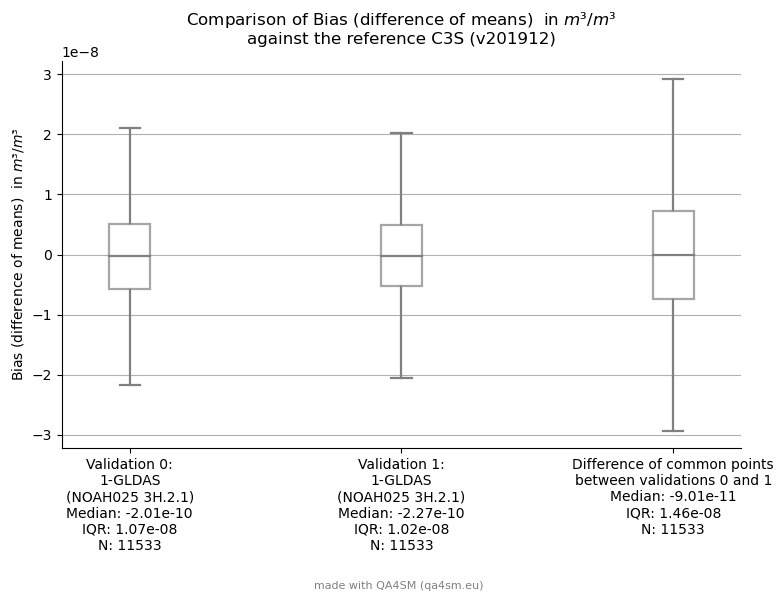

In [6]:
comp.diff_boxplot('BIAS')

Alternatively, a boxplot of the pairwise differences between the two validations could be shown, together with the individual results of the two validations:

#### Difference mapplot

A mapplot provides spatial information on the difference of performance between two validations. The colorbar is reversed when a negative difference means better performance, e.g.:

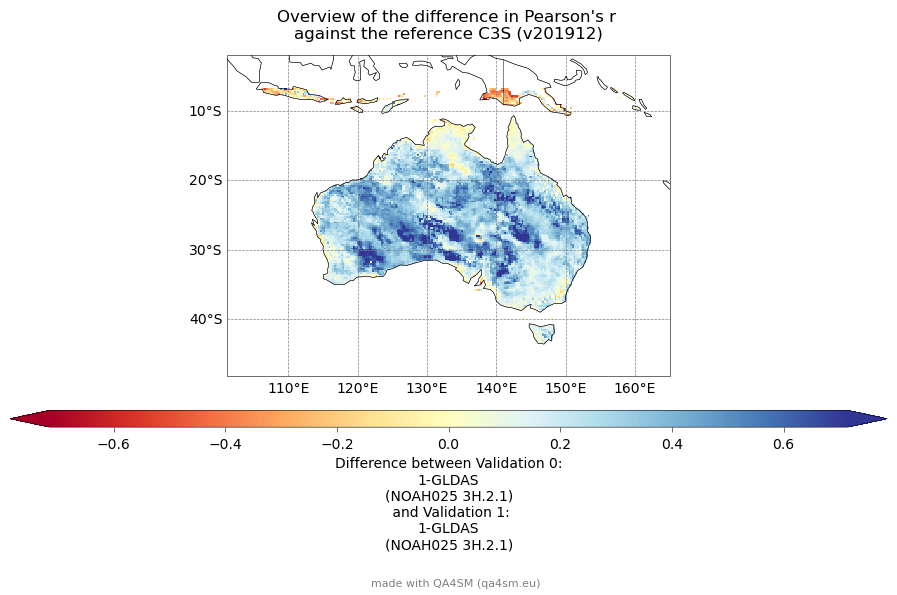

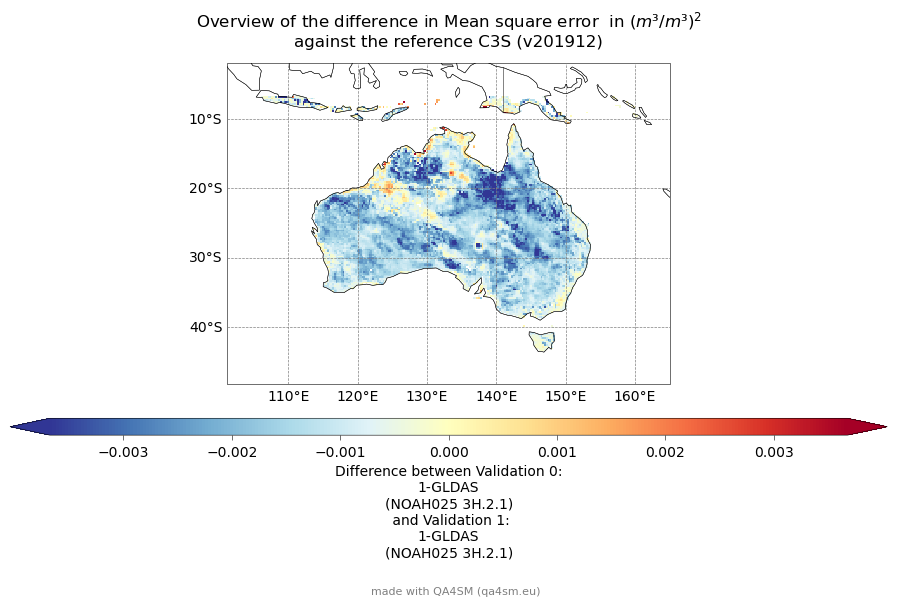

In [7]:
comp.diff_mapplot('R')
comp.diff_mapplot('mse')

### Comparing different spatial subsets

Different validations may use different spatial subsets, which can completely overlap, intersect or correspond to entirely separate regions. This can create problems as some of the comparison methods depend on point-wise comparisons. Specifically, maps and correlation plots provide a point-by-point comparison. These methods therefore cannot be used to compare validations with non-overlapping spatial extents. To work around this, a flow diagram is established:

1. If `'extent'` is specified as class parameter, we take this extent, when valid, and perform the comparison over it. Otherwise, an error is thrown.
2. If the extent is not given, by default the class is initialized considering only the data present within the overlapping space of the two validations. If the validations are not overlapping, an error will be thrown to warn the user.
3. If the extent is not given and `get_intersection` is set to `False`, the comparison will take place between all the data present in each validation. In this case, using pairwise comparison methods will throw errors.

Let's now walk through this flow diagram. We can initialize two validation results, one with a spatial subset over Australia, one shifted to north-west, and see how the choice between union and intersection of the validation results plays out:

In [8]:
from qa4sm_reader.img import QA4SMImg

# paths to the validations with different spatial selections:
paths_subsets = ['0-C3S.sm_with_1-GLDAS.SoilMoi0_10cm_inst.nc', '0-C3S.sm_with_1-GLDAS.SoilMoi40_100cm_inst.diff_subset.nc']

for path in paths_subsets:
    img = QA4SMImg(path)
    print('Spatial extent of a single image:', img.extent)

Spatial extent of a single image: (106.125, 160.125, -43.375, -6.875)
Spatial extent of a single image: (92.625, 155.375, -27.875, 12.125)


In [9]:
%%time
# when we take the intersection, the initialization can be slow
comp_subsets = QA4SMComparison(paths_subsets)  # default: intersection of the spatial subsets

CPU times: user 1.1 s, sys: 79.9 ms, total: 1.18 s
Wall time: 1.18 s


We have now now initialized the comparison and we can see the two different spatial subsets:

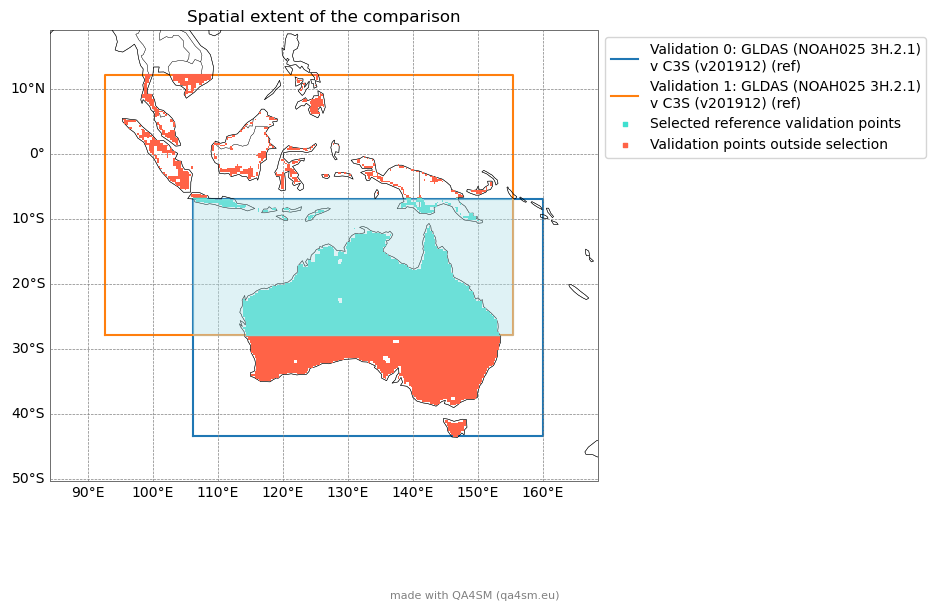

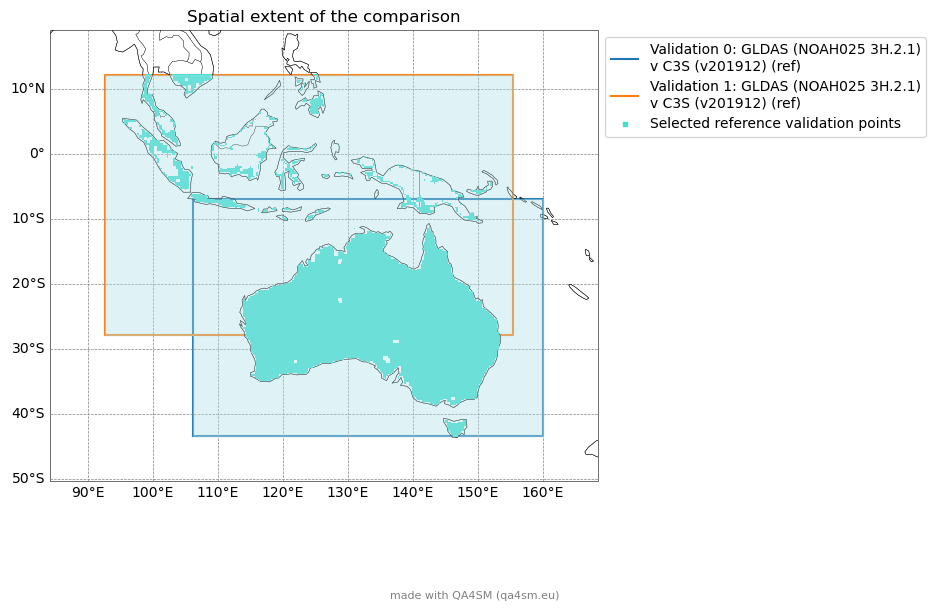

In [10]:
# method to visualize the outputs of union/intersection
comp_subsets.visualize_extent(plot_points=True)
comp_subsets.visualize_extent(intersection=False, plot_points=True)

Let's now select an extent over which to perform the validation:

In [11]:
%%time
comp_subsets = QA4SMComparison(paths_subsets, extent=(120, 140, -30, -10))

CPU times: user 1.01 s, sys: 64 ms, total: 1.08 s
Wall time: 1.08 s


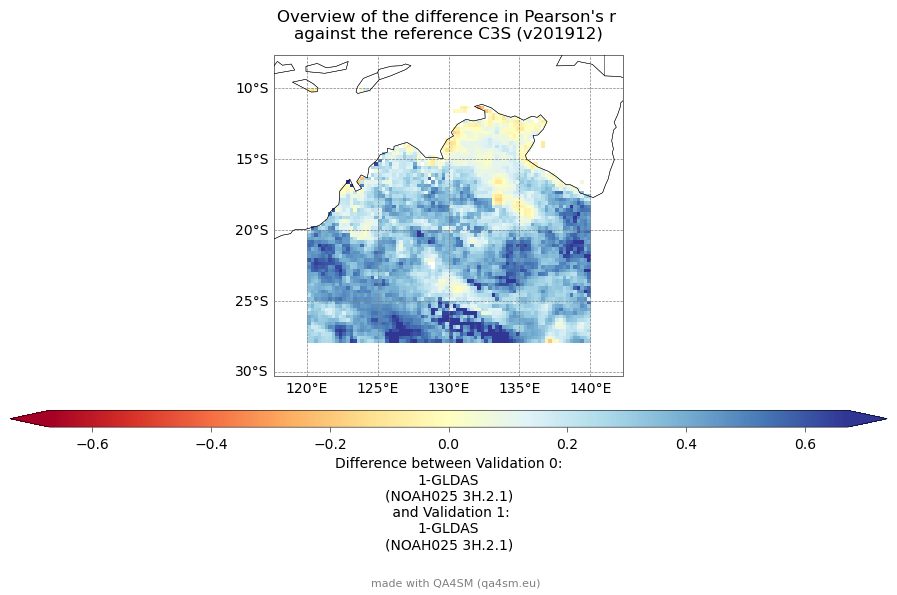

In [12]:
comp_subsets.diff_mapplot('R')

You can see that the comparison is performed correctly over our bounding box. Because one of the validations hase no points below ~-28 degrees South, these points do not show up.

Let's look deeper into what happens with the default settings. Because the default is `get_intersection=True`, all comparison methods (pairwise and not) provide results:

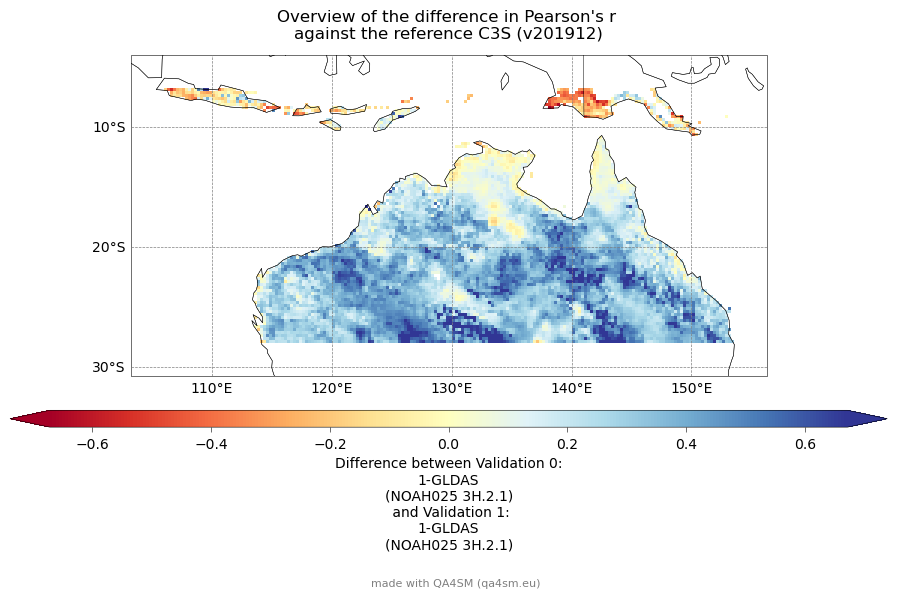

In [13]:
comp_subsets = QA4SMComparison(paths_subsets)  # default: intersection of the spatial subsets
comp_subsets.diff_mapplot('R')

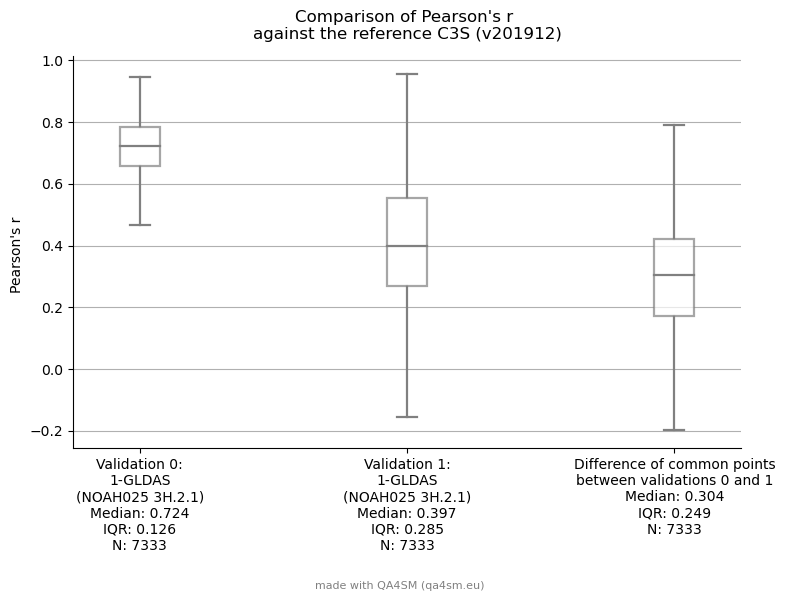

In [14]:
# the boxplots will be now different, as we are taking the intersection subset only
comp_subsets.diff_boxplot('R')

If instead we take the union, only `diff_table` and `diff_boxplot` can be used, while the pairwise methods throw errors. For instance:

In [15]:
%%time
# we can do either:
comp_subsets.init_union()

CPU times: user 1.11 s, sys: 64.1 ms, total: 1.17 s
Wall time: 1.17 s


In [16]:
%%time
# or:
comp_subsets = QA4SMComparison(paths_subsets, get_intersection=False)

CPU times: user 1.13 s, sys: 44.1 ms, total: 1.17 s
Wall time: 1.17 s


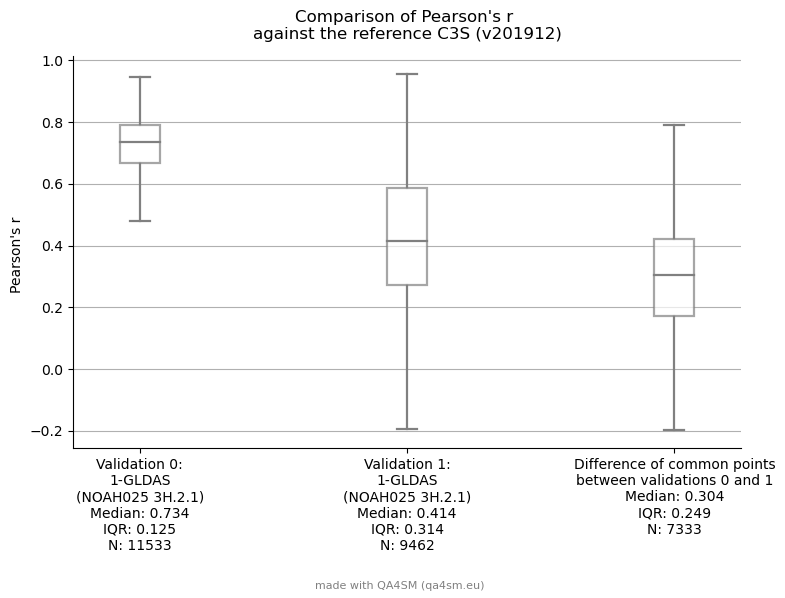

In [17]:
comp_subsets.diff_boxplot('R')

In [18]:
# mapplot cannot be computed either
from qa4sm_reader.comparing import SpatialExtentError

try:
    comp_subsets.diff_mapplot('R') 
except SpatialExtentError:
    print("This won't work")

This won't work


### Intra-validation comparison

The comparison methods can be useful even when comparing two datasets that have been compared to the same reference in the same validation run. This might actually make the comparison more immediate as we are considering the same time and space subsets, as well as scaling functions applied. In this case, the path to a netCDF file containing (at least) three datasets can be provided as input to the class.

**Note**: the methods work at the moment only for validations with 2 satellite datasets
**Note2**: the diff_table method has yet to be implemented for this case

In [19]:
%%time
comp = QA4SMComparison('0-ERA5.swvl1_with_1-ESA_CCI_SM_combined.sm_with_2-ESA_CCI_SM_combined.sm.nc')

CPU times: user 681 ms, sys: 44 ms, total: 725 ms
Wall time: 725 ms


In [20]:
comp.diff_table(comp.common_metrics.keys())

,Validation 0: ESA CCI SM combined (v06.1) validated against ERA5 (v20190613),Validation 1: ESA CCI SM combined (v05.2) validated against ERA5 (v20190613),Difference of the medians (0 - 1)
Pearson's r [-],0.58,0.57,5.27e-03
Pearson's r p-value [-],~ 0,~ 0,~ 0
Spearman's rho [-],0.55,0.55,9.12e-03
Spearman's rho p-value [-],~ 0,~ 0,~ 0
Root-mean-square deviation [m³/m³],5.23e-02,5.34e-02,~ 0
Bias (difference of means) [m³/m³],~ 0,~ 0,~ 0
Unbiased root-mean-square deviation [m³/m³],5.23e-02,5.34e-02,~ 0
Mean square error [(m³/m³)²],2.73e-03,2.85e-03,~ 0
Mean square error correlation [(m³/m³)²],2.73e-03,2.85e-03,~ 0
Mean square error bias [(m³/m³)²],~ 0,~ 0,~ 0


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


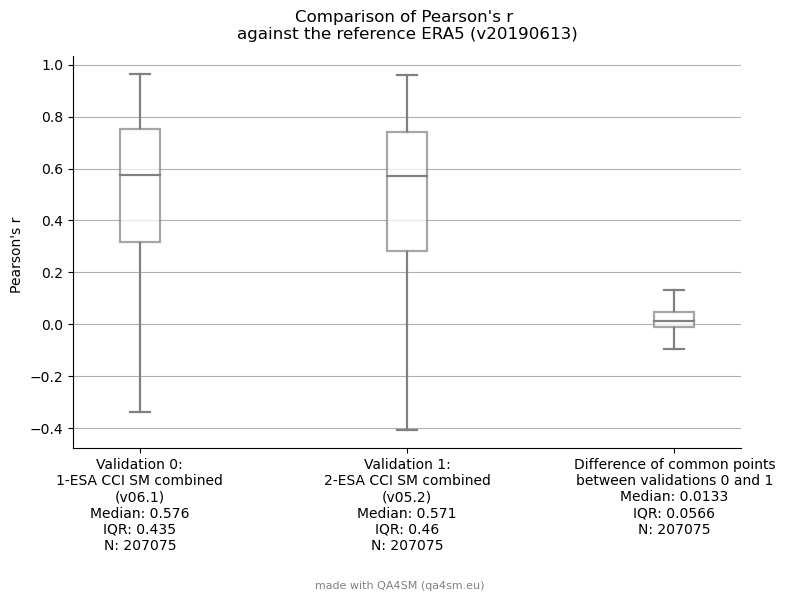

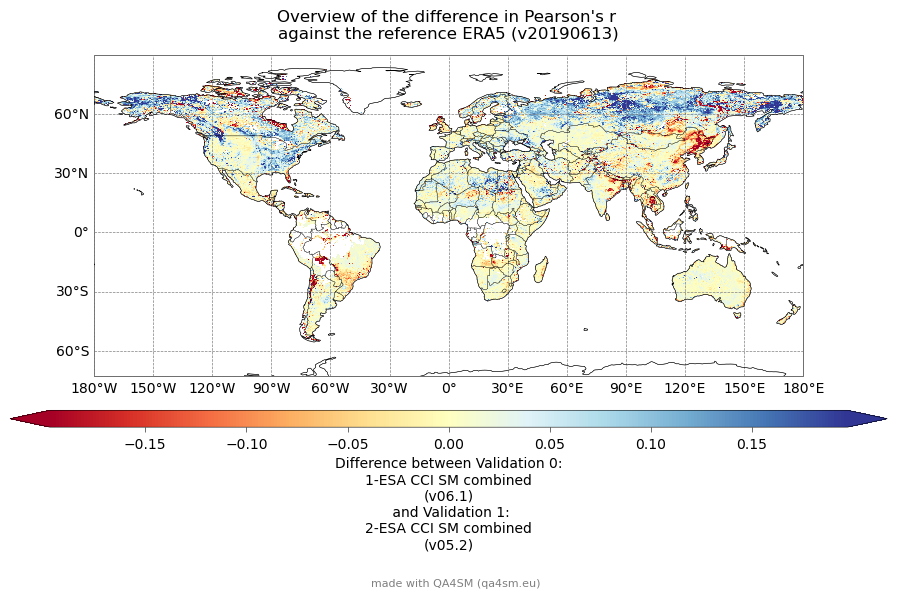

In [21]:
%time
comp.diff_boxplot('R')
comp.diff_mapplot('R')